# Create pseudo panel dataset

In [1]:
import pandas as pd
import numpy as np 
import os
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product

C:\Users\wotererio_user\AppData\Local\Temp\ipykernel_7704\283265172.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Create category corresponding to Age weight
# Define a function to categorize the 'agea' values
def categorize_age(age):
    if pd.isna(age) or age == 0:
        return 0  # Missing
    elif 15 <= age <= 34:
        return 1  # 15-34 years old
    elif 35 <= age <= 54:
        return 2  # 35-54 years old
    elif age >= 55:
        return 3  # 55+ years old
    else:
        return 0  # Default to Missing for any unexpected values
    

# Function to map the education level to a 3-point scale
def categorize_education(level):
    if level in [1, 2]:
        return 1  # Basic Education
    elif level in [3, 4]:
        return 2  # Secondary Education & Vocational Training
    elif level in [5, 6, 7]:
        return 3  # Tertiary Education
    else:
        return None  # Handle unexpected values, if any
    

In [18]:
df = pd.read_csv(f"{Path.cwd().parent.parent}/ESS/ESS_data.csv", low_memory=False)

# Subset data for which info about education is available
## ES - ISCED = highest level of education
df = df[df.eisced < 10]
df = df[df.eisced != 0] # remove observations for which the eisced could not be harmonised 
df = df[df.essround < 11] # remove round 11, no post stratification weights available yet
df = df[df.gndr != 9] # remove people without gender
df['weight'] = df.pspwght * df.pweight

# Apply the function to create a new column 'age_group'
df['age_group'] = df['agea'].apply(categorize_age)
df = df[df.age_group != 0]

# Apply the function to create a new column with the 3-point scale
df['education_group'] = df['eisced'].apply(categorize_education)
df = df[df.education_group != 0]

df.stfgov = df.stfgov.astype(int)

variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround'] # create cohorts

# Recode missing data (77=refusal, 88=dont know, 99=no answer)
df.loc[:,variables_of_interest] = df.loc[:,variables_of_interest].replace({77: np.nan, 88: np.nan, 99: np.nan}).astype(pd.Int64Dtype())


df = df[variables_of_interest + grouping_variables]

C:\Users\wotererio_user\AppData\Local\Temp\ipykernel_7704\3690847270.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   7,    5,    5,    2,    3,    3,    7,    5,    7, <NA>,
 ...
    2,    6,    5,    8,    5,    8,    6,    2,    7,    3]
Length: 413372, dtype: Int64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,variables_of_interest] = df.loc[:,variables_of_interest].replace({77: np.nan, 88: np.nan, 99: np.nan}).astype(pd.Int64Dtype())
C:\Users\wotererio_user\AppData\Local\Temp\ipykernel_7704\3690847270.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   6,    6,    8,    8,    7,    2,    7, <NA>,    6,    5,
 ...
   10,    4,    9,    8,    9,    5,    6,    5,    5,    7]
Length: 413372, dtype: Int64' has dtype incompatible with int64, please e

## Create the pseudo panel

In [27]:
variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround']

# Step 1: Create a full grid of all possible cohorts (including time)
unique_values = {col: df[col].unique() for col in grouping_variables}
full_cohort_space = pd.DataFrame(list(product(*unique_values.values())), columns=grouping_variables)

# Step 2: Group the actual data and calculate means for the variables of interest
grouped_mean_df = df.groupby(grouping_variables)[variables_of_interest].mean().reset_index()

# Step 3: Merge the full cohort space with the grouped data (this will introduce NaNs for missing cohorts)
full_pseudo_df = pd.merge(full_cohort_space, grouped_mean_df, on=grouping_variables, how='left')


- Cast to a tensor of shape NxTxK+1 (since Y is included)

In [29]:
import numpy as np

# Define the grouping variables (the cohorts) and the variables of interest
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group']
variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']

# Step 1: Sort the DataFrame by the grouping variables and time point (essround)
full_pseudo_df = full_pseudo_df.sort_values(grouping_variables + ['essround'])
# Step 2: Make sure there is exactly one observation per cohort per time point (i.e., no duplicates)
# If duplicates exist, you'll need to handle them appropriately (e.g., by dropping or aggregating)
# For now, let's assume there are no duplicates

# Step 3: Convert to a NumPy array and reshape into (N, T, K)
# N = number of unique cohorts, T = number of time points, K = number of variables of interest
N = full_pseudo_df.drop_duplicates(subset=grouping_variables).shape[0]  # Number of unique cohorts
T = full_pseudo_df['essround'].nunique()  # Number of time points
K = len(variables_of_interest)  # Number of variables of interest

# Extract the data to be reshaped
data_values = full_pseudo_df[variables_of_interest].values

# Reshape the data into a 3D array (N x T x K)
tensor = data_values.reshape(N, T, K)

# Step 4: Verify the shape of the resulting tensor
print("Shape of the tensor (N, T, K):", tensor.shape)


Shape of the tensor (N, T, K): (684, 10, 5)


- Create the GMM weighting matrix
    - Cell corresponds to the number of observations for cohort N at time T

In [16]:
# Step 1: Create a full grid of all possible cohorts (including time)
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround']
## Same as before, however, the NaN's will be 0 since no observations are available for those timepoints
unique_values = {col: df[col].unique() for col in grouping_variables}
full_cohort_space = pd.DataFrame(list(product(*unique_values.values())), columns=grouping_variables)

# Step 2: Group the actual data and count the number of observations per cohort
grouped_count_df = df.groupby(grouping_variables)[variables_of_interest].size().reset_index(name = 'count')

# Step 3: Merge the full cohort space with the grouped data (this will introduce NaNs for missing cohorts)
full_weight_df = pd.merge(full_cohort_space, grouped_count_df, on=grouping_variables, how='left')



# Step 4: Replace NaN values with 0 in the 'count' column
full_weight_df['count'] = full_weight_df['count'].fillna(0)


In [17]:
full_cohort_space.columns

Index(['cntry', 'gndr', 'age_group', 'education_group', 'essround'], dtype='object')

- Reshape it into a NxT weighting matrix

In [7]:
# Pivot the DataFrame to create a matrix of counts for each cohort and ESS round
pivot_counts = full_weight_df.pivot_table(index=grouping_variables[:-1], columns='essround', values='count')

# Convert the pivoted DataFrame into a NumPy array
weighting_matrix = pivot_counts.values

# Show the shape of the resulting weighting matrix (N x T)
print("Shape of the weighting matrix (N, T):", weighting_matrix.shape)

# Print the matrix to check
print(weighting_matrix)

KeyError: 'essround'

- Percentage NA per round

In [35]:
# Checks how many entries are 0, which correspond to NA entries
((pivot_counts == 0).sum(axis = 0))/pivot_counts.shape[0]

essround
1     0.657895
2     0.605263
3     0.631579
4     0.473684
5     0.289474
6     0.236842
7     0.447368
8     0.394737
9     0.236842
10    0.184211
dtype: float64

----------------------

# Analyse the source of the missingness

In [40]:
# Step 1: Create a binary indicator for missingness
full_pseudo_df['is_missing'] = full_pseudo_df[variables_of_interest].isnull().any(axis=1).astype(int)

# Optional: You can also calculate the percentage of missing values for each cohort
full_pseudo_df['missing_percentage'] = full_pseudo_df[variables_of_interest].isnull().mean(axis=1) * 100


In [48]:
# Group the data by country and ESS round
grouped_country_round = full_pseudo_df.groupby(['cntry', 'essround'])['is_missing'].mean().reset_index()


In [49]:
# Group the data by country and ESS round
grouped_country_round = full_pseudo_df.groupby(['cntry', 'essround'])['is_missing'].mean().reset_index()

# Create a pivot table where each row is a country and each column is an ESS round
pivot_missing_country_round = grouped_country_round.pivot_table(index='cntry', columns='essround', values='is_missing')

# Step 2: Identify countries with entire rounds missing (i.e., all cohorts missing for a given round)
# If a value is 1 for an entire column, it means that the round is completely missing for that country
fully_missing_rounds = pivot_missing_country_round[pivot_missing_country_round == 1].dropna(how='all')

# Display the countries and ESS rounds with complete missingness
print(fully_missing_rounds)


essround   1    2    3    4    5    6    7    8    9    10
cntry                                                     
AL        1.0  1.0  1.0  1.0  1.0  NaN  1.0  1.0  1.0  1.0
AT        1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN
BG        1.0  1.0  1.0  1.0  NaN  NaN  1.0  1.0  NaN  NaN
CY        1.0  1.0  1.0  1.0  NaN  NaN  1.0  1.0  NaN  NaN
CZ        NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
DK        NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0
EE        1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
FI        1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN
FR        1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
GB        1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN
GR        1.0  1.0  1.0  1.0  NaN  1.0  1.0  1.0  1.0  NaN
HR        1.0  1.0  1.0  NaN  NaN  1.0  1.0  1.0  NaN  NaN
IE        1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN
IL        NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  1.0  NaN
IS        1.0  NaN  1.0  1.0  1.0  NaN  1.0  NaN  NaN  N

In [42]:
# Step 2: Aggregate missingness by each cohort (grouping variables excluding 'essround')
missing_by_cohort = full_pseudo_df.groupby(grouping_variables)['is_missing'].mean().reset_index()

# You can also sort to see which cohorts have the highest missingness
missing_by_cohort = missing_by_cohort.sort_values(by='is_missing', ascending=False)

# Display the most missing cohorts
print(missing_by_cohort.head(10))


     cntry  gndr  age_group  education_group  essround  is_missing
0       AL     1          1                1         1         1.0
3880    LT     2          1                2         1         1.0
3892    LT     2          1                3         3         1.0
3891    LT     2          1                3         2         1.0
3890    LT     2          1                3         1         1.0
3883    LT     2          1                2         4         1.0
3882    LT     2          1                2         3         1.0
3881    LT     2          1                2         2         1.0
3873    LT     2          1                1         4         1.0
3941    LT     2          3                2         2         1.0


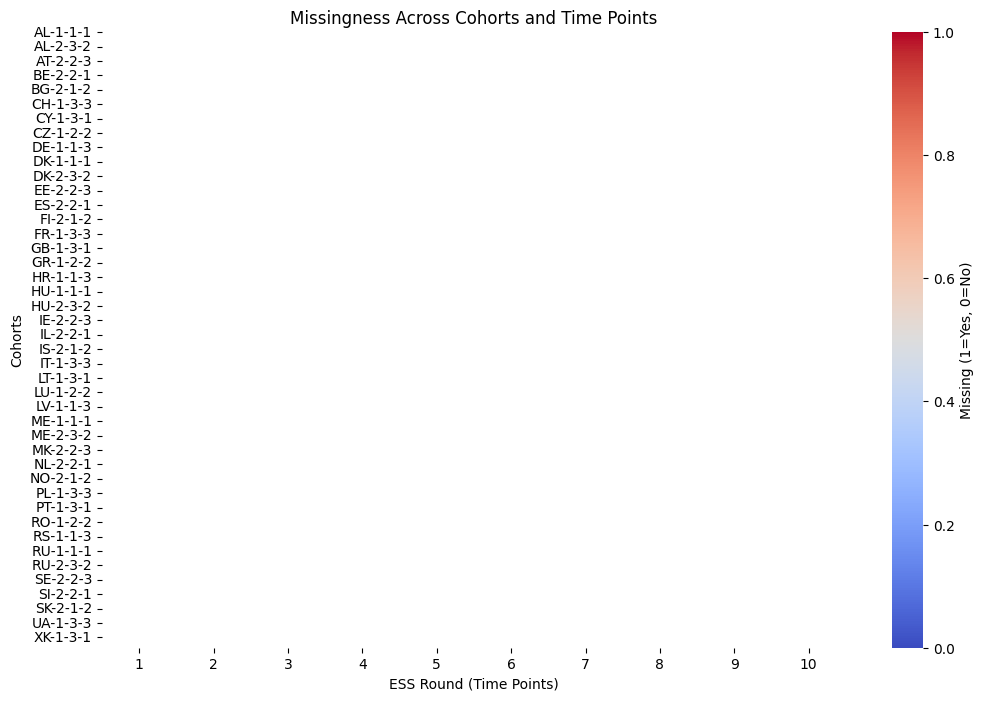

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data for the heatmap
missing_heatmap_data = full_pseudo_df.pivot_table(index=grouping_variables[:-1], columns='essround', values='is_missing')

# Plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(missing_heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Missing (1=Yes, 0=No)'}, linewidths=.5)
plt.title('Missingness Across Cohorts and Time Points')
plt.xlabel('ESS Round (Time Points)')
plt.ylabel('Cohorts')
plt.show()


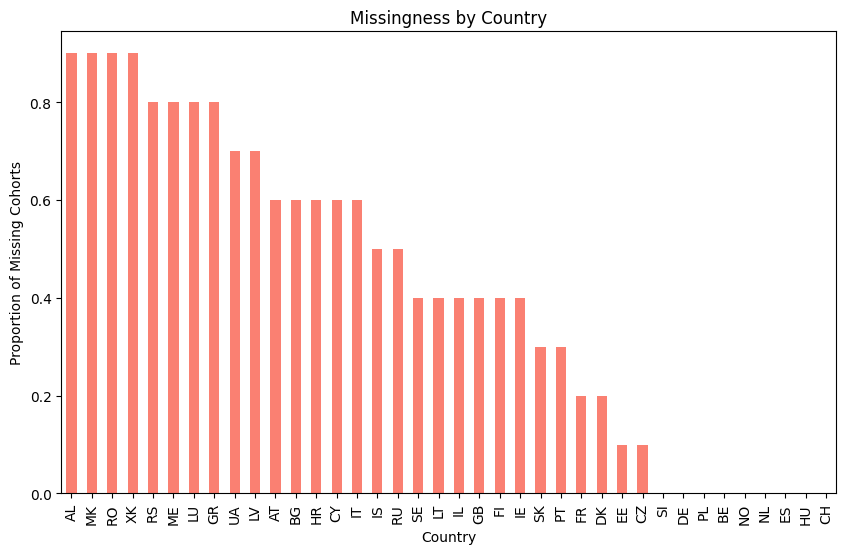

In [45]:
# Step 3: Aggregate missingness by country, gender, etc.
missing_by_group = full_pseudo_df.groupby('cntry')['is_missing'].mean().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10,6))
missing_by_group.plot(kind='bar', color='salmon')
plt.title('Missingness by Country')
plt.xlabel('Country')
plt.ylabel('Proportion of Missing Cohorts')
plt.show()


-------------------

In [13]:
N = pseudo_df.groupby(grouping_variables[:-1]).ngroups
T = df.essround.nunique()  # T: Number of unique time points (essround)
K = len(variables_of_interest)-1  # K: Number of variables of interest, minus Y

In [8]:
N

684

In [6]:
pseudo_df.shape

(3996, 5)

In [11]:
T

10